<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [ ]:
# from PyQt5.QtGui.QRawFont import weight
# !if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
# !unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
!pip install ./deepul


[hw2_data.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of hw2_data.zip or
        hw2_data.zip.zip, and cannot find hw2_data.zip.ZIP, period.


In [5]:
from deepul.hw2_helper import *
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn
import torch.nn.utils as utils
from torch import nn
from tqdm import tqdm

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


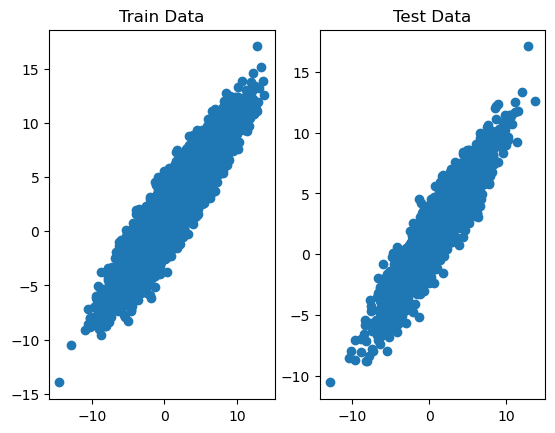

Dataset 2


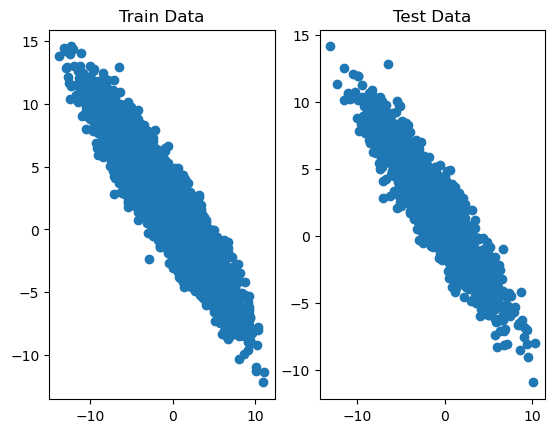

In [2]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [31]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    class ToyDataset(Dataset):
        def __init__(self, data: np.array):
            self.data = data

        def __len__(self):
            return self.data.shape[0]

        def __getitem__(self, idx):
            return self.data[idx]


    class VAE(nn.Module):
        def __init__(self, input_size: int, hidden_size: int, latent_size: int):
            super(VAE, self).__init__()

            self.input_size = input_size
            self.latent_size = latent_size

            self.encoder = nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 2 * latent_size))
            self.decoder = nn.Sequential(nn.Linear(latent_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 2 * input_size))

        def encode(self, x):
            z = self.encoder(x)
            mu  = z[:, :self.latent_size]
            logsvar = z[:, self.latent_size:]
            std = torch.exp(0.5 * logsvar)
            eps = torch.randn_like(std)

            z = eps * std + mu
            return z, mu, logsvar

        def decode(self, z, return_mean=False):
            h = self.decoder(z)
            mu = h[:, :self.input_size]
            logsvar = h[:, self.input_size:]
            if return_mean:
                return mu
            std = torch.exp(0.5 * logsvar)
            eps = torch.randn_like(std)

            return eps * std + mu

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            z, mu, logsvar = self.encode(x)

            # Return mean for reconstruction loss, not noisy sample
            recon_mean = self.decode(z, return_mean=True)

            return recon_mean, mu, logsvar


        def sample(self, num: int, with_noise: bool) -> torch.Tensor:
            z = torch.randn((num, self.latent_size))
            if with_noise:
                return self.decode(z, return_mean=False).detach().numpy()
            else:
                return self.decode(z, return_mean=True).detach().numpy()


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = "cpu"
    print(device)

    train_dataset = ToyDataset( train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    test_dataset = ToyDataset(test_data)
    test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    model = VAE(2, 512, 2).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)

    train_losses = []
    test_losses = []
    for e in tqdm(range(10)):
        model.train()
        for X in train_dataloader:
            logits, mu, logsvar = model(X.to(device))

            optimizer.zero_grad()

            mse = F.mse_loss(logits, X, reduction='mean')
            kl_loss = -0.5 * torch.mean(1 + logsvar - mu ** 2 - torch.exp(logsvar))
            loss = mse + kl_loss

            loss.backward()
            optimizer.step()

            train_losses.append(np.array([loss.item(), mse.item(), kl_loss.item()]))


        mse = 0
        kl_loss = 0
        model.eval()
        with torch.no_grad():
            for Y in test_dataloader:

                logits, mu, logsvar = model(Y.to(device))
                mse += F.mse_loss(logits, Y, reduction='sum')
                kl_loss += -0.5 * torch.sum(1 + logsvar - mu ** 2 - torch.exp(logsvar))

            mse /= len(test_dataset)
            kl_loss /= len(test_dataset)
            ll = mse + kl_loss
            test_losses.append(np.array([ll.item(), mse.item(), kl_loss.item()]))


    model.eval()
    samples_with_noise = model.sample(1000, with_noise=True)
    samples = model.sample(1000, with_noise=False)

    return np.stack(train_losses), np.stack(test_losses), samples_with_noise, samples

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

cpu


100%|██████████| 10/10 [00:00<00:00, 20.30it/s]


Final -ELBO: 3.3475, Recon Loss: 1.0620, KL Loss: 2.2856


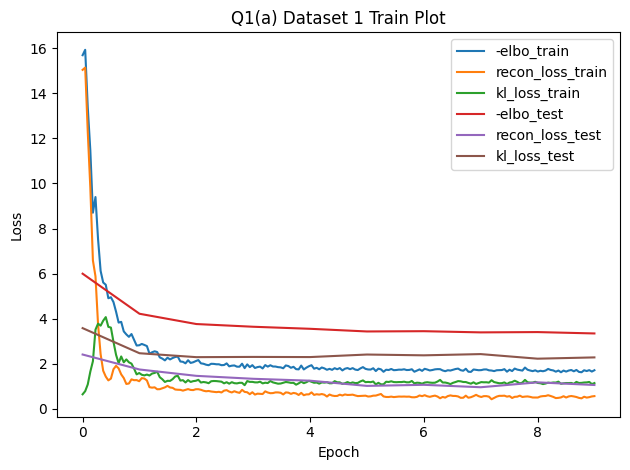

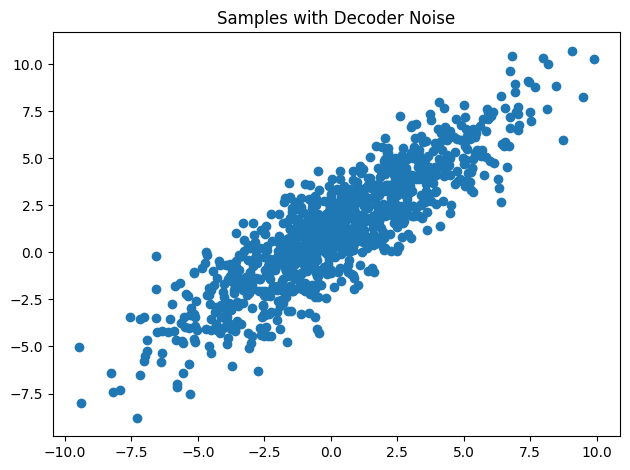

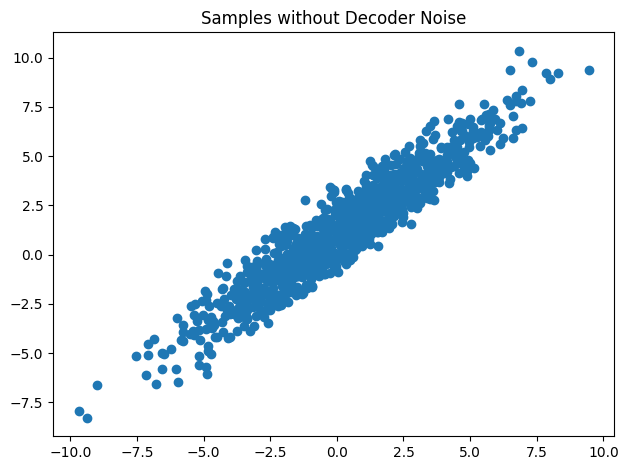

In [32]:
q1_save_results('a', 1, q1)

cpu


100%|██████████| 10/10 [00:00<00:00, 20.06it/s]


Final -ELBO: 3.4002, Recon Loss: 1.0417, KL Loss: 2.3585


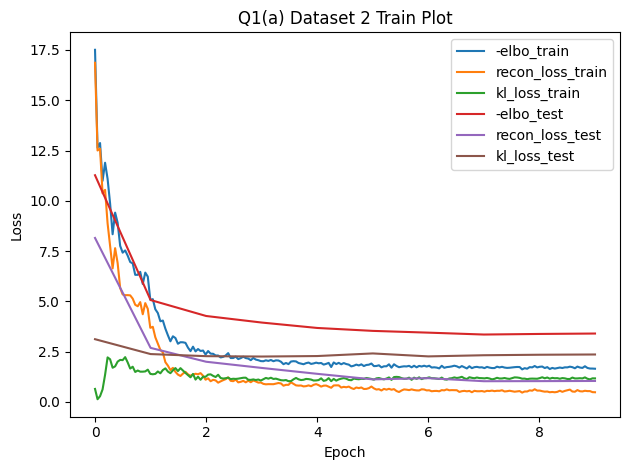

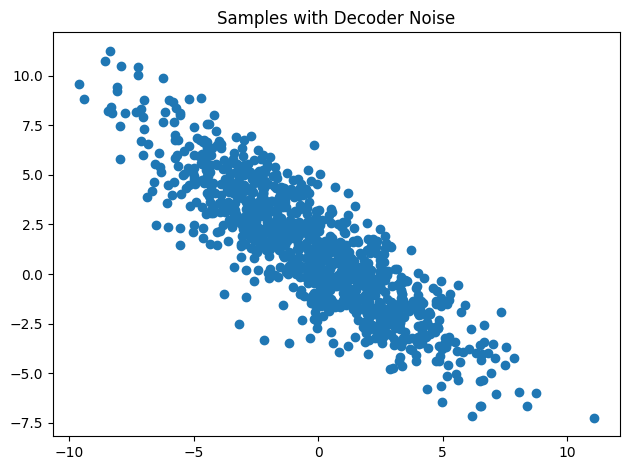

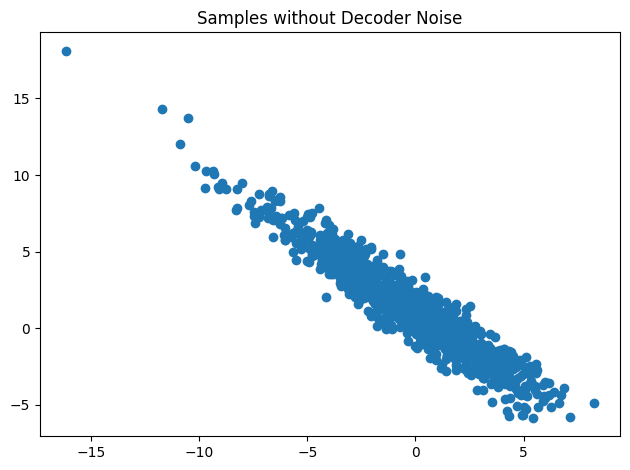

In [33]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


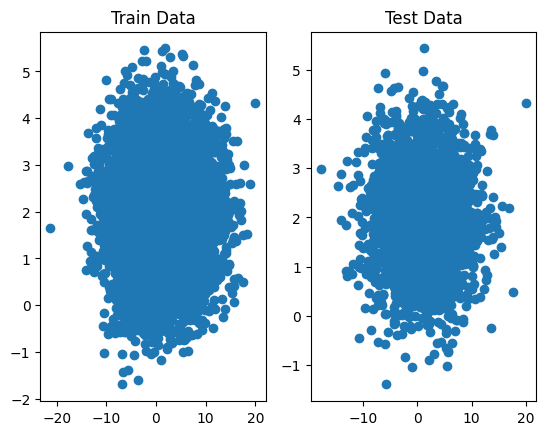

Dataset 2


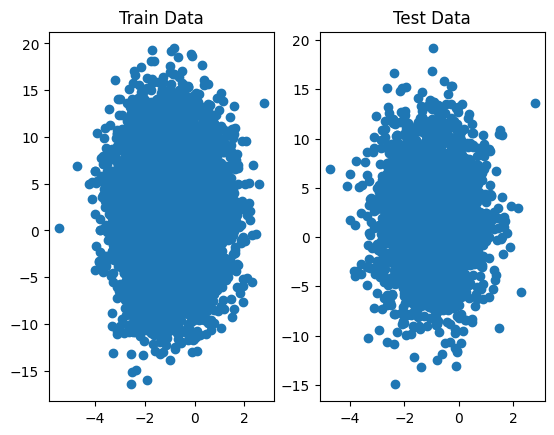

In [34]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

cpu


100%|██████████| 10/10 [00:00<00:00, 20.12it/s]


Final -ELBO: 3.3721, Recon Loss: 1.0332, KL Loss: 2.3389


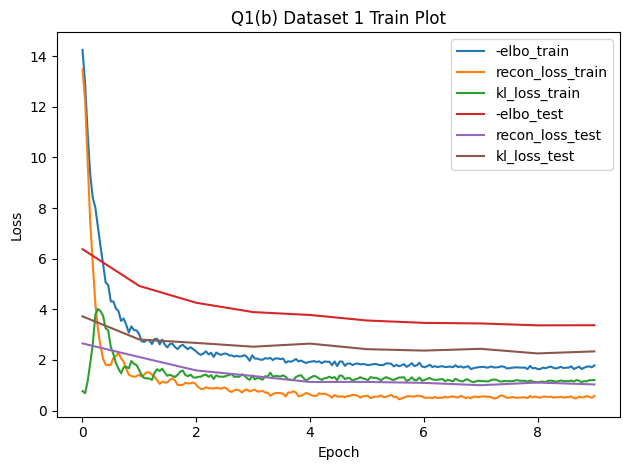

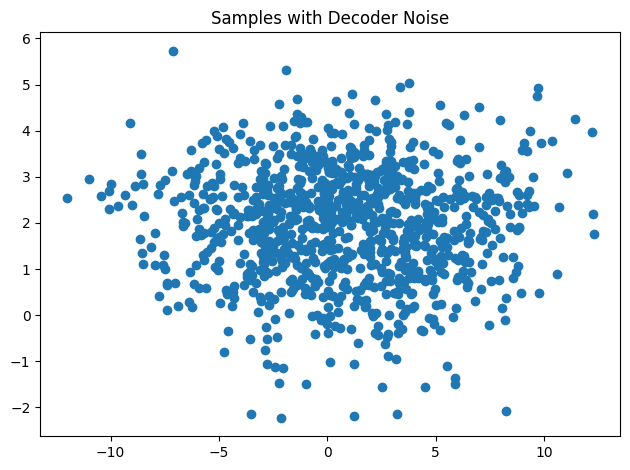

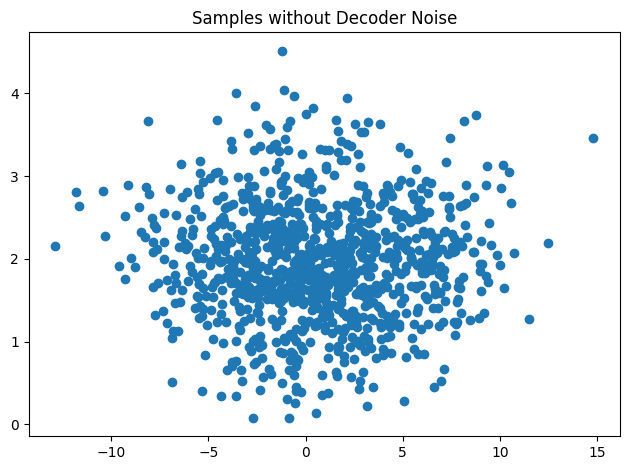

In [35]:
q1_save_results('b', 1, q1)

cpu


100%|██████████| 10/10 [00:00<00:00, 20.32it/s]


Final -ELBO: 3.3444, Recon Loss: 1.1190, KL Loss: 2.2254


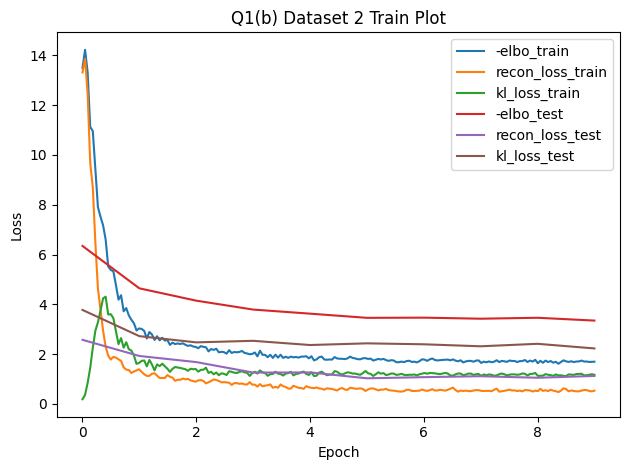

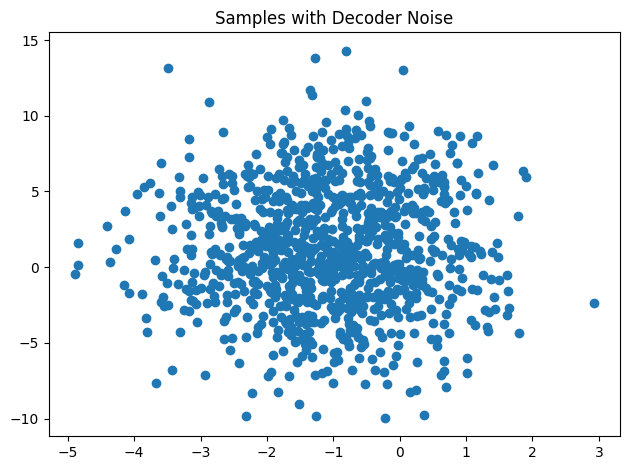

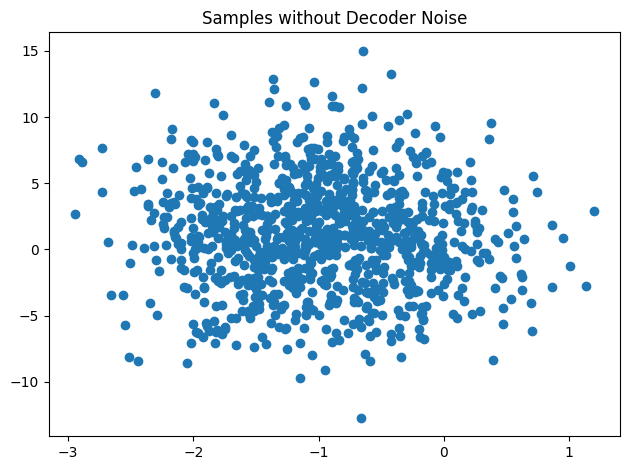

In [36]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

In [20]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

dataset = {}
dataset['train'] = np.array(unpickle("data/cifar-10-batches-py/data_batch_1")[b'data'])
dataset['train'] = np.concatenate([dataset['train'], np.array(unpickle("data/cifar-10-batches-py/data_batch_2")[b'data'])], axis=0)
dataset['train'] = np.concatenate([dataset['train'], np.array(unpickle("data/cifar-10-batches-py/data_batch_3")[b'data'])], axis=0)
dataset['train'] = np.concatenate([dataset['train'], np.array(unpickle("data/cifar-10-batches-py/data_batch_4")[b'data'])], axis=0)
dataset['train'] = np.concatenate([dataset['train'], np.array(unpickle("data/cifar-10-batches-py/data_batch_5")[b'data'])], axis=0)
dataset['train'] = dataset['train'].reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
dataset['test'] = np.array(unpickle("data/cifar-10-batches-py/test_batch")[b'data'])
dataset['test'] = dataset['test'].reshape((-1, 3, 32, 32)).transpose((0, 2, 3, 1))
print(dataset['train'].shape, dataset['test'].shape)

with open("data/cifar10.pkl", "wb") as f:
    pickle.dump(dataset, f)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
!mv data/cifar10.pkl deepul/homeworks/hw2/data/cifar10.pkl

In [23]:
import scipy.io

dataset = {}
train = scipy.io.loadmat("data/SVHN/train_32x32.mat")
dataset['train'] = train['X'].transpose((3, 0, 1, 2))

test = scipy.io.loadmat("data/SVHN/test_32x32.mat")
dataset['test'] = test['X'].transpose((3, 0, 1, 2))

print(dataset['train'].shape, dataset['test'].shape)

with open("data/svhn.pkl", "wb") as f:
    pickle.dump(dataset, f)

(73257, 32, 32, 3) (26032, 32, 32, 3)


In [27]:
!mv data/svhn.pkl deepul/homeworks/hw2/data/svhn.pkl

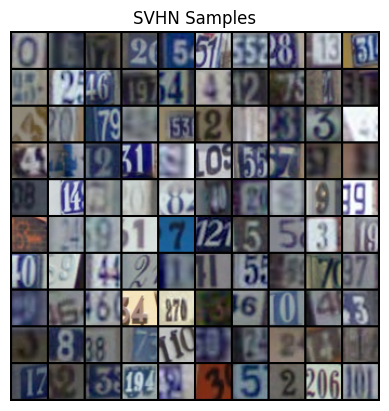

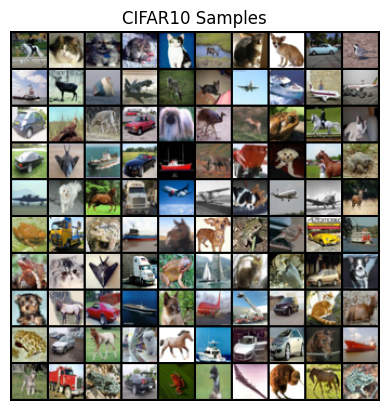

In [28]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [39]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    class ImageDataset(Dataset):
        def __init__(self, data: np.array):
            self.data = data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.

        def __len__(self):
            return self.data.shape[0]

        def __getitem__(self, idx):
            return self.data[idx]


    class VAE(nn.Module):
        def __init__(self, latent_size: int):
            super(VAE, self).__init__()

            self.latent_size = latent_size

            self.encoder = nn.Sequential(nn.Conv2d(3, 32, 3, 1, 1),
                                        nn.ReLU(),
                                        nn.Conv2d(32, 64, 3, 2, 1), # 16 x 16
                                        nn.ReLU(),
                                        nn.Conv2d(64, 128, 3, 2, 1), # 8 x 8
                                        nn.ReLU(),
                                        nn.Conv2d(128, 256, 3, 2, 1), # 4 x 4
                                        nn.ReLU(),
                                        nn.Flatten(), # 16
                                        nn.Linear(4 * 4 * 256, 2 * self.latent_size))
            self.decoder = nn.Sequential(nn.Linear(self.latent_size, 4 * 4 * 128),
                                        nn.ReLU(),
                                        nn.Unflatten(1, (128, 4, 4)),
                                        nn.ConvTranspose2d(128, 128, 4, 2, 1), # 8 x 8
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(128, 64, 4, 2, 1), # 16 x 16
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32 x 32
                                        nn.ReLU(),
                                        nn.Conv2d(32, 3, 3, 1, 1))

        def encode(self, x):
            z = self.encoder(x)
            mu  = z[:, :self.latent_size]
            logsvar = z[:, self.latent_size:]
            std = torch.exp(0.5 * logsvar)
            eps = torch.randn_like(std, device=x.device)

            z = eps * std + mu
            return z, mu, logsvar

        def decode(self, z, return_mean=False):
            mu = self.decoder(z)
            if return_mean:
                return F.sigmoid(mu)
            eps = torch.randn_like(mu, device=z.device) / 255.
            return F.sigmoid(mu) + eps

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            z, mu, logsvar = self.encode(x)

            # Return mean for reconstruction loss, not noisy sample
            recon_mean = self.decode(z, return_mean=True)

            return recon_mean, mu, logsvar


    def sample_new(model, num: int, device) -> np.array:
        z = torch.randn((num, model.latent_size), device=device)
        out = model.decode(z, return_mean=False).permute(0, 2, 3, 1) * 255
        return out.detach().cpu().numpy().astype(np.uint8)

    def sample_reconstruction(model, x: torch.tensor) -> np.array:
        z, _, _ = model.encode(x)
        out = model.decode(z, return_mean=True)
        h = torch.cat([x, out], dim=0).detach().cpu().numpy() * 255
        indices = torch.arange(2 * x.shape[0]).view(2, -1).T.flatten()
        return h[indices].astype(np.uint8).transpose(0, 2, 3, 1)

    def sample_interpolation(model, x: torch.tensor) -> np.array:
        z, _, _ = model.encode(x)
        # print(z.shape)
        z = z.view(-1, 2, z.shape[1])
        # print(z.shape)
        weights = torch.linspace(0, 1, 10).view(-1, 1, 1).to(x.device)
        # print(weights.shape, z[:, 0].shape)

        z_line = (1 - weights) * z[:, 0] + weights * z[:, 1]
        z_line = z_line.view(-1, z.shape[2])
        # print(z_line.shape)

        out = model.decode(z_line, return_mean=True) * 255
        # h = torch.cat([x, out], dim=0).detach().cpu().numpy() * 255
        # indices = torch.arange(2 * x.shape[0]).view(2, -1).T.flatten()
        return out.type(torch.uint8).permute(0, 2, 3, 1).detach().cpu().numpy()


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = "cpu"
    print(device)

    train_dataset = ImageDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    test_dataset = ImageDataset(test_data)
    test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    model = VAE(1024).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    epoch = 80
    BETA = 1.

    train_losses = []
    test_losses = []
    for e in tqdm(range(epoch)):
        model.train()
        BETA = min(1.0, e / 15)
        for X in train_dataloader:
            X = X.to(device)
            logits, mu, logsvar = model(X)

            optimizer.zero_grad()

            mse = F.mse_loss(logits, X, reduction='sum') / X.shape[0]
            kl_loss = -0.5 * BETA * torch.sum(1 + logsvar - mu ** 2 - torch.exp(logsvar)) / X.shape[0]
            loss = mse + kl_loss

            train_losses.append(np.array([loss.item(), mse.item(), kl_loss.item()]))

            loss.backward()
            optimizer.step()



        mse = 0
        kl_loss = 0
        model.eval()
        with torch.no_grad():
            for Y in test_dataloader:
                Y = Y.to(device)
                logits, mu, logsvar = model(Y)
                mse += F.mse_loss(logits, Y, reduction='sum')
                kl_loss += -0.5 * BETA * torch.sum(1 + logsvar - mu ** 2 - torch.exp(logsvar))

            mse /= len(test_dataset)
            kl_loss /= len(test_dataset)
            ll = mse + kl_loss
            test_losses.append(np.array([ll.detach().cpu(), mse.detach().cpu(),  kl_loss.detach().cpu()]))
            # tqdm.write(f"{ll.detach().cpu().item()} {mse.detach().cpu().item()} {kl_loss.detach().cpu().item()}")


    model.eval()
    samples = sample_new(model, 100, device)
    print(samples.shape, samples.max(), samples.min())
    reconstruction = sample_reconstruction(model, torch.tensor(test_dataset[:50]).to(device))
    print(reconstruction.shape, reconstruction.max(), reconstruction.min())
    interpolation = sample_interpolation(model, torch.tensor(test_dataset[:20]).to(device))

    return np.stack(train_losses), np.stack(test_losses), samples, reconstruction, interpolation

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

cuda:0


100%|██████████| 80/80 [01:56<00:00,  1.46s/it]

(100, 32, 32, 3) 227 13
(100, 32, 32, 3) 255 0
Final -ELBO: 38.7975, Recon Loss: 27.2844, KL Loss: 11.5131


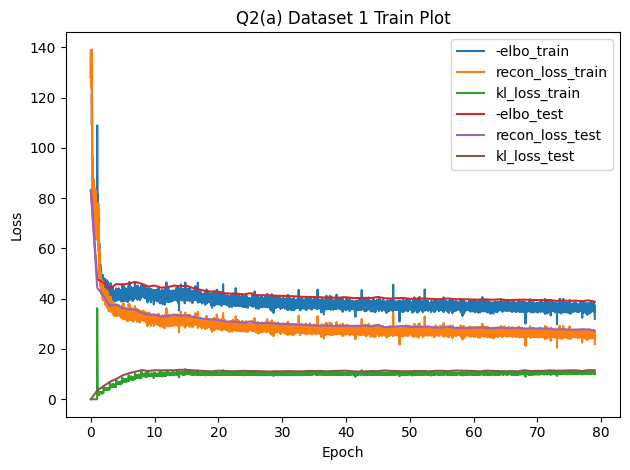

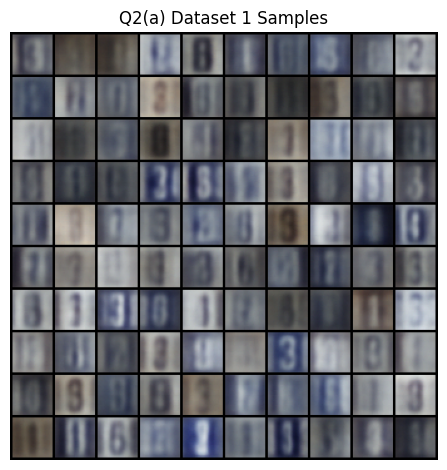

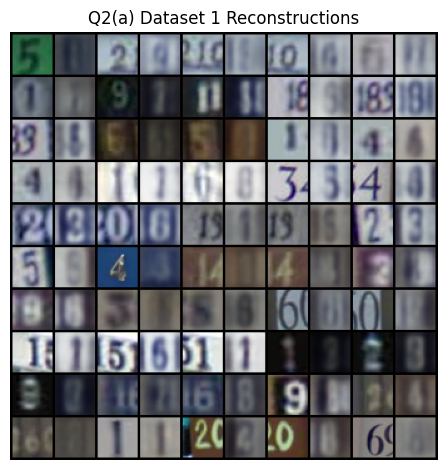

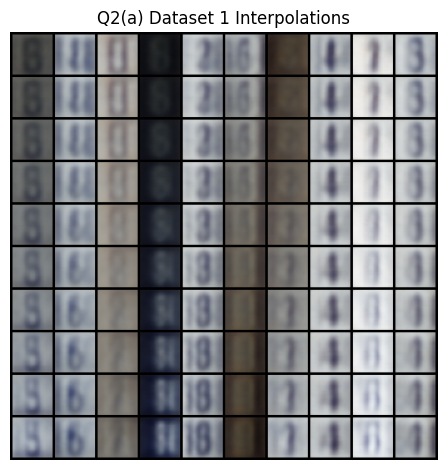

In [40]:
q2_save_results('a', 1, q2_a)

cuda:0


100%|██████████| 80/80 [01:16<00:00,  1.05it/s]

(100, 32, 32, 3) 252 4
(100, 32, 32, 3) 255 0
Final -ELBO: 78.7933, Recon Loss: 58.6628, KL Loss: 20.1304


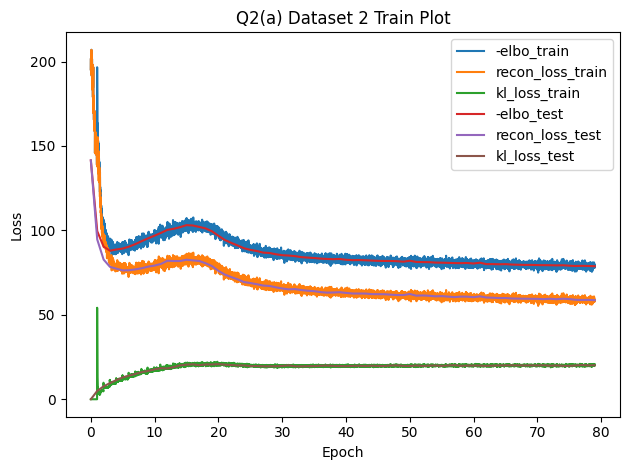

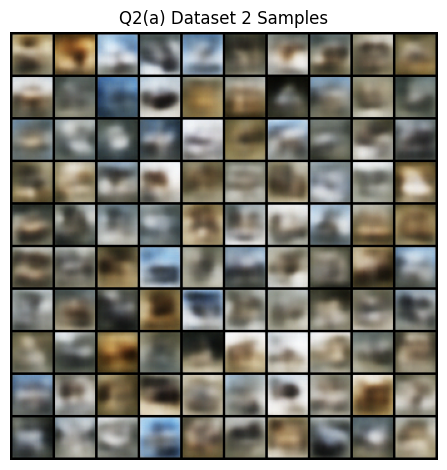

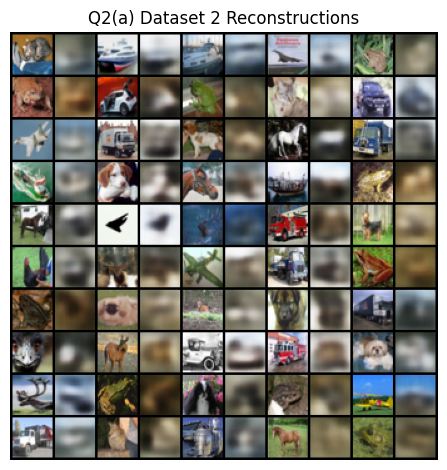

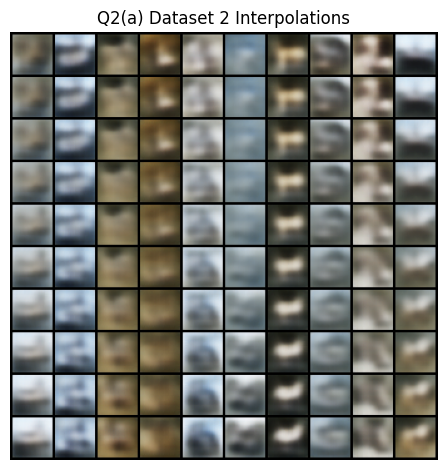

In [41]:
q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [53]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    class ImageDataset(Dataset):
        def __init__(self, data: np.array):
            self.data = data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.

        def __len__(self):
            return self.data.shape[0]

        def __getitem__(self, idx):
            return self.data[idx]


    class VAE(nn.Module):
        def __init__(self, latent_size: int):
            super(VAE, self).__init__()

            self.latent_size = 12  # channels
            # z1 has fixed prior N(0, I), not learnable parameters


            self.input_encoder = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1), # [32, 32, 32]
                                        nn.BatchNorm2d(32),
                                        nn.ReLU(),
                                        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 64, 3, stride=2, padding=1),) # [64, 8, 8]
                                        # nn.InstanceNorm2d(64),
                                        # nn.ReLU(),
                                        # nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
                                        # nn.InstanceNorm2d(64),
                                        # nn.ReLU(),
                                        # nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
                                        # nn.InstanceNorm2d(64),
                                        # nn.ReLU(),
                                        # nn.Conv2d(64, 12*2, 3, padding=1)) # [12*2, 2, 2])

            self.encoder = nn.Sequential(
                                        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Conv2d(64, 12*2, 3, padding=1)) # [12*2, 2, 2])

            self.upscale = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1))

            self.decoder1 = nn.Sequential(nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
                                          # nn.LayerNorm([64, 2, 2]),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
                                          # nn.LayerNorm([64, 4, 4]),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1),) # [64, 8, 8]
                                        # nn.ReLU(),
                                        # nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
                                        # nn.ReLU(),
                                        # nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
                                        # nn.ReLU(),
                                        # nn.Conv2d(32, 3, 3, padding=1)) # [3, 32, 32])


            self.decoder2 = nn.Sequential(nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
                                          # nn.LayerNorm([64, 16, 16]),
                                            nn.ReLU(),
                                            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 32, 32]
                                          # nn.LayerNorm([64, 32, 32]),
                                            nn.ReLU(),
                                            nn.Conv2d(64, 3, 3, padding=1)) # [3, 32, 32])

        def encode(self, x):
            h2 = self.input_encoder(x)
            enc = self.upscale(h2)
            z2_dmu, z2_dlogvar  = enc[:, :64], enc[:, 64:]
            # z2 = self._sample_gaussian(z2_mu, z2_logvar, x.device)

            h1 = self.encoder(h2)
            z1_dmu, z1_dlogvar  = h1[:, :12], h1[:, 12:]
            # z1 = self._sample_gaussian(z1_mu, z1_logvar, x.device)
            # print("z1", z1.shape)

            return z1_dmu, z1_dlogvar, z2_dmu, z2_dlogvar

        def sample(self, num: int, device):
            # Sample z1 from fixed prior p(z1) = N(0, I)
            z1 = torch.randn((num, 12, 2, 2), device=device)

            # Sample z2 from prior p(z2|z1) with fixed std=1
            h2 = self.decoder1(z1)
            dec2 = self.upscale(h2)
            z2_prior_mu = dec2[:, :64]  # Mean of p(z2|z1)
            z2_prior_std = torch.ones_like(z2_prior_mu)  # Fixed std=1
            z2 = self._sample_gaussian(z2_prior_mu, z2_prior_std, device)

            out = F.sigmoid(self.decoder2(z2 + h2))
            return out

        def _sample_gaussian(self, mu, std, device):
            eps = torch.randn_like(std, device=device)
            return mu + eps * std

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            device = x.device
            z1_delta_mu, z1_delta_logvar, z2_delta_mu, z2_delta_logvar = self.encode(x)
            
            # q(z1|x): posterior for z1, prior p(z1) = N(0, I)
            z1_delta_std = torch.exp(0.5 * z1_delta_logvar)
            # Sample z1 from q(z1|x) = N(z1_delta_mu, z1_delta_std^2)
            z1 = self._sample_gaussian(z1_delta_mu, z1_delta_std, device)

            # p(z2|z1): prior for z2 (learned, fixed std=1)
            h2 = self.decoder1(z1)
            dec2 = self.upscale(h2)
            z2_prior_mu = dec2[:, :64]  # Mean of p(z2|z1)
            z2_prior_std = torch.ones_like(z2_prior_mu)  # Fixed std=1 for p(z2|z1)
            
            # q(z2|z1,x): residual normal posterior
            # q(z2|z1,x) = N(z2_prior_mu + z2_delta_mu, z2_prior_std^2 * exp(z2_delta_logvar))
            z2_delta_std = torch.exp(0.5 * z2_delta_logvar)
            z2_posterior_mu = z2_prior_mu + z2_delta_mu
            z2_posterior_std = z2_prior_std * z2_delta_std
            z2 = self._sample_gaussian(z2_posterior_mu, z2_posterior_std, device)

            out = F.sigmoid(self.decoder2(z2 + h2))
            return out, z1_delta_mu, z1_delta_logvar, z2_delta_mu, z2_delta_logvar, z2_prior_mu

    def sample_new(model, num: int, device) -> np.array:
        out = model.sample(num, device).detach().cpu().numpy() * 255
        return out.astype(np.uint8).transpose(0, 2, 3, 1)

    def sample_reconstruction(model, x: torch.tensor) -> np.array:
        out, _, _, _, _, _ = model(x)
        h = torch.cat([x, out], dim=0).detach().cpu().numpy() * 255
        indices = torch.arange(2 * x.shape[0]).view(2, -1).T.flatten()
        return h[indices].astype(np.uint8).transpose(0, 2, 3, 1)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = "cpu"
    print(device)

    train_dataset = ImageDataset(train_data)
    train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    test_dataset = ImageDataset(test_data)
    test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

    epoch = 50
    model = VAE(12).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch, eta_min=1e-4)

    BETA_1 = 1.
    BETA_2 = 1.

    train_losses = []
    test_losses = []
    for e in tqdm(range(epoch)):
        BETA_1 = min(1.0, e / 15)
        BETA_2 = min(1.0, e / 15)
        model.train()
        for X in train_dataloader:
            X = X.to(device)
            logits, z1_delta_mu, z1_delta_logvar, z2_delta_mu, z2_delta_logvar, z2_prior_mu = model(X)
            # print(logits.shape, X.shape)

            optimizer.zero_grad()

            mse = F.mse_loss(logits, X, reduction='sum') / X.shape[0]
            
            # KL for z1: KL(q(z1|x) || N(0, I))
            # q(z1|x) = N(z1_delta_mu, exp(z1_delta_logvar))
            # p(z1) = N(0, I)
            kl_z1 = 0.5 * BETA_1 * torch.sum(-1 - z1_delta_logvar + z1_delta_mu ** 2 + torch.exp(z1_delta_logvar), dim=[1, 2, 3]).mean()
            
            # KL for z2: KL(q(z2|z1,x) || p(z2|z1)) using residual normal formula
            # q(z2|z1,x) = N(z2_prior_mu + z2_delta_mu, z2_prior_std^2 * exp(z2_delta_logvar))
            # p(z2|z1) = N(z2_prior_mu, z2_prior_std^2) where z2_prior_std = 1
            # Using residual normal formula: kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5
            z2_residual_logstd = 0.5 * z2_delta_logvar  # log(std) = 0.5 * log(var)
            z2_residual_mu = z2_delta_mu  # residual mean
            kl_z2 = BETA_2 * torch.sum(-z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5, dim=[1, 2, 3]).mean()
            # print(mse, kl_z1, kl_z2)

            loss = mse + kl_z1 + kl_z2

            train_losses.append(np.array([loss.item(), mse.item(), (kl_z1 + kl_z2).item()]))

            loss.backward()
            # utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()


        cosine_scheduler.step()
        mse = 0
        kl1 = 0
        kl2 = 0
        model.eval()
        with torch.no_grad():
            for Y in test_dataloader:
                Y = Y.to(device)
                logits, z1_delta_mu, z1_delta_logvar, z2_delta_mu, z2_delta_logvar, z2_prior_mu = model(Y)
                mse += F.mse_loss(logits, Y, reduction='sum')
                
                # KL for z1: KL(q(z1|x) || N(0, I))
                kl1 += 0.5 * BETA_1 * torch.sum(-1 - z1_delta_logvar + z1_delta_mu ** 2 + torch.exp(z1_delta_logvar), dim=[1, 2, 3]).sum()
                
                # KL for z2: using residual normal formula
                z2_residual_logstd = 0.5 * z2_delta_logvar
                z2_residual_mu = z2_delta_mu
                kl2 += BETA_2 * torch.sum(-z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5, dim=[1, 2, 3]).sum()

            mse /= len(test_dataset)
            kl1 /= len(test_dataset)
            kl2 /= len(test_dataset)
            ll = mse + kl1 + kl2
            # tqdm.write(f"{ll.detach().cpu().item():.2f} {mse.detach().cpu().item():.2f} {kl1.detach().cpu().item():.2f} {kl2.detach().cpu().item():.2f}")
            test_losses.append(np.array([ll.detach().cpu(), mse.detach().cpu(),  (kl1 + kl2).detach().cpu()]))


    model.eval()
    samples = sample_new(model, 100, device)
    # print(samples.shape, samples.max(), samples.min())
    reconstruction = sample_reconstruction(model, torch.tensor(test_dataset[:50]).to(device))
    # print(reconstruction.shape, reconstruction.max(), reconstruction.min())
    # interpolation = sample_interpolation(model, torch.tensor(test_dataset[:50]).to(device))

    return np.stack(train_losses), np.stack(test_losses), samples, reconstruction, reconstruction


### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

cuda:0


100%|██████████| 50/50 [01:32<00:00,  1.84s/it]

Final -ELBO: 37.3375, Recon Loss: 25.5379, KL Loss: 11.7996


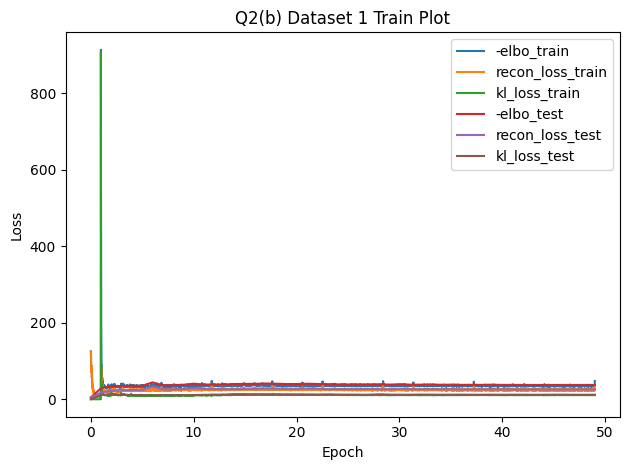

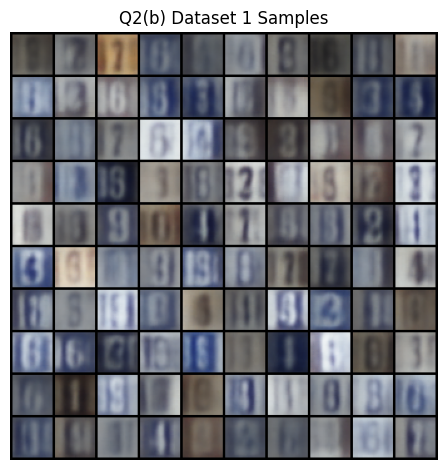

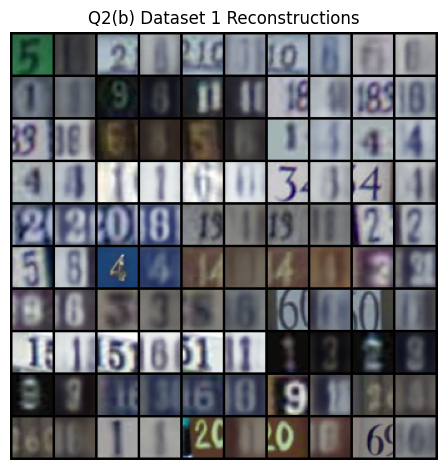

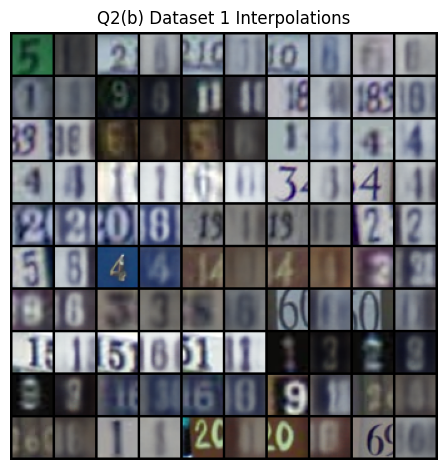

In [54]:
q2_save_results('b', 1, q2_b)

cuda:0


100%|██████████| 50/50 [00:59<00:00,  1.19s/it]

Final -ELBO: 78.9506, Recon Loss: 59.0487, KL Loss: 19.9020


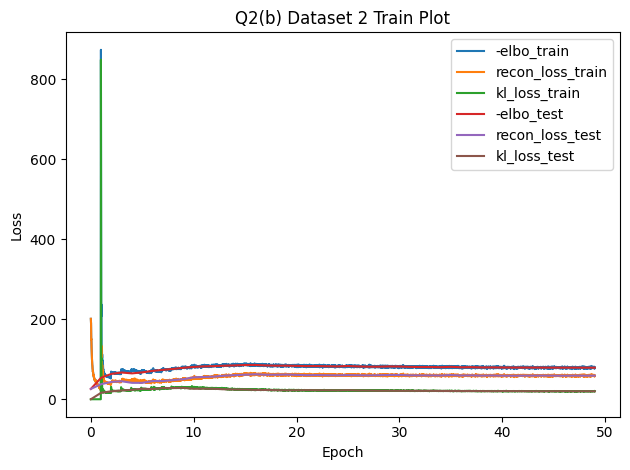

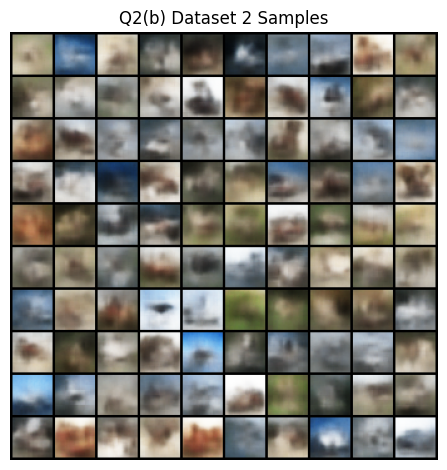

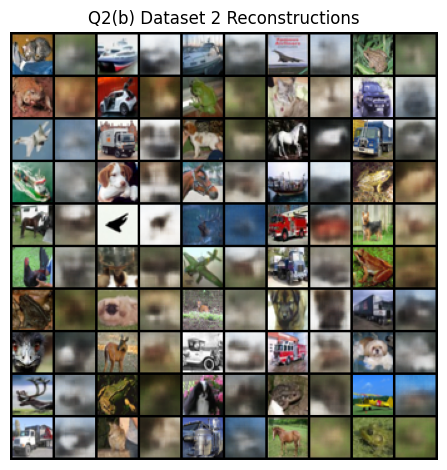

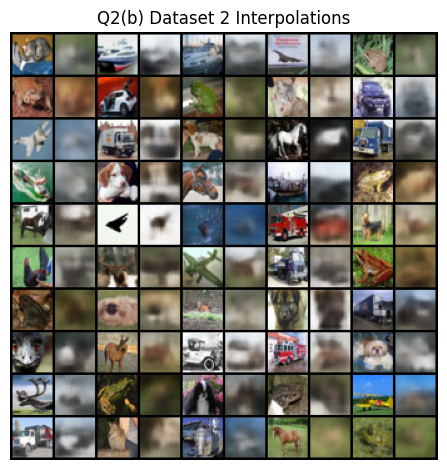

In [45]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

In [ ]:
q3_save_results(1, q3)

In [ ]:
q3_save_results(2, q3)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)